# TCN-VAE (Temporal Convolutional Network - Variational Autoencoder)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
sys.path.append('../../')
from utils.metrics import calculate_anomaly_metrics, format_results

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

2025-11-21 10:42:52.475242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 10:42:52.518263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 10:42:53.810917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# 1. CARGAR DATOS
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 2. FEATURES
feature_cols = [
'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_21'
]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Features: {len(feature_cols)}")

Train shape: (53759, 24)
Test shape: (33991, 23)
Features: 18


In [3]:
# 3. CREAR BASELINE (30% primeros ciclos)
def get_baseline(df, pct=0.3):
    baseline_list = []
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit]
        cutoff = unit_data['time_cycles'].max() * pct
        baseline_list.append(unit_data[unit_data['time_cycles'] <= cutoff])
    return pd.concat(baseline_list)

baseline = get_baseline(train)

# 4. NORMALIZACIÓN
scaler = StandardScaler()
scaler.fit(baseline[feature_cols].values)

print(f"Baseline samples: {len(baseline)}")
print(f"Features: {len(feature_cols)}")

Baseline samples: 16010
Features: 18


In [4]:
# 5. CREAR SECUENCIAS TEMPORALES
window_size = 50  # Ventana de 50 ciclos para TCN

def create_sequences(df, feature_cols, window_size, scaler):
    """
    Crea secuencias temporales para cada unidad.
    Retorna: (sequences, indices) donde indices mapea cada secuencia al índice original
    """
    sequences = []
    indices = []
    
    for unit in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit].sort_values('time_cycles')
        values = scaler.transform(unit_data[feature_cols].values)
        
        # Crear ventanas deslizantes
        for i in range(len(values) - window_size + 1):
            sequences.append(values[i:i+window_size])
            # Guardar índice del último punto de la ventana
            indices.append(unit_data.index[i + window_size - 1])
    
    return np.array(sequences), np.array(indices)

# Crear secuencias para baseline
X_baseline, baseline_indices = create_sequences(baseline, feature_cols, window_size, scaler)

print(f"Baseline sequences: {X_baseline.shape}")
print(f"Sequence shape: (samples={X_baseline.shape[0]}, timesteps={X_baseline.shape[1]}, features={X_baseline.shape[2]})")

Baseline sequences: (3468, 50, 18)
Sequence shape: (samples=3468, timesteps=50, features=18)


In [5]:
# 6. ARQUITECTURA TCN-VAE
timesteps = window_size
n_features = len(feature_cols)
latent_dim = 16

# Sampling layer para el espacio latente
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ENCODER con TCN (1D Convolutions)
encoder_inputs = layers.Input(shape=(timesteps, n_features))
x = layers.Conv1D(64, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# DECODER
latent_inputs = layers.Input(shape=(latent_dim,))
# Calcular la dimensión después de los poolings
pooled_timesteps = timesteps // 4  # 2 poolings de factor 2

x = layers.Dense(pooled_timesteps * 256, activation='relu')(latent_inputs)
x = layers.Reshape((pooled_timesteps, 256))(x)

x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling1D(2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
# Add zero padding to match original timesteps if needed
x = layers.ZeroPadding1D(padding=(0, timesteps - pooled_timesteps * 4))(x)
decoder_outputs = layers.Conv1D(n_features, 3, padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

encoder.summary()
print('\n')
decoder.summary()

2025-11-21 10:42:54.498536: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 64)    │      3,520 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 25, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 25, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 12, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 128)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 256)   │     98,560 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 256)   │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,800 (534.38 KB)

 Trainable params: 135,904 (530.88 KB)

 Non-trainable params: 896 (3.50 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3072)           │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 48, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d (ZeroPadding1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 50, 18)         │         3,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,170 (1.44 MB)

 Trainable params: 376,402 (1.44 MB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
# 7. MODELO VAE COMPLETO
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Unpack the data - fit() passes (x, y) as a tuple
        if isinstance(data, tuple):
            data = data[0]  # We only need the input, target is the same for autoencoders
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=(1, 2)
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            total_loss = reconstruction_loss + 0.01 * kl_loss  # Beta = 0.01
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

print("VAE model created successfully")

VAE model created successfully


In [7]:
# 8. ENTRENAR EN BASELINE
early_stop = keras.callbacks.EarlyStopping(
    monitor='total_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='total_loss',
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = vae.fit(
    X_baseline, X_baseline,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - kl_loss: 5.2209 - reconstruction_loss: 889.4606 - total_loss: 889.5128 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - kl_loss: 21.4800 - reconstruction_loss: 878.2141 - total_loss: 878.4288 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 40.0163 - reconstruction_loss: 859.0352 - total_loss: 859.4354 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - kl_loss: 47.1100 - reconstruction_loss: 840.0215 - total_loss: 840.4926 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - kl_loss: 51.1684 - reconstruction_loss: 824.0585 - total_loss: 824.5700 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - kl_loss: 52.2043 - reconstruction_loss: 815.3173 - total_loss: 815.8394 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 54.8983 - reconstruction_loss: 804.422

In [8]:
# 9. CALCULAR ERROR EN BASELINE Y DEFINIR UMBRAL
X_baseline_reconstructed = vae.predict(X_baseline)
baseline_errors = np.mean(np.mean((X_baseline - X_baseline_reconstructed)**2, axis=2), axis=1)

# Umbral: percentil 99 del baseline
threshold = np.percentile(baseline_errors, 99)
print(f"Umbral (p99): {threshold:.6f}")
print(f"Error medio baseline: {baseline_errors.mean():.6f}")
print(f"Error std baseline: {baseline_errors.std():.6f}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Umbral (p99): 0.481056
Error medio baseline: 0.287032
Error std baseline: 0.078913


In [ ]:
# 10. DETECTAR ANOMALÍAS EN TRAIN
X_train, train_indices = create_sequences(train, feature_cols, window_size, scaler)
X_train_reconstructed = vae.predict(X_train)

# Error de reconstrucción para cada secuencia
sequence_errors = np.mean(np.mean((X_train - X_train_reconstructed)**2, axis=2), axis=1)

# Inicializar columnas
train['reconstruction_error'] = 0.0
train['is_anomaly'] = 0

# Asignar errores a los índices correspondientes
for idx, error in zip(train_indices, sequence_errors):
    train.loc[idx, 'reconstruction_error'] = error
    train.loc[idx, 'is_anomaly'] = int(error > threshold)

# Propagar valores para las primeras ventanas (que no tienen secuencia)
for unit in train['unit_id'].unique():
    unit_mask = train['unit_id'] == unit
    unit_data = train[unit_mask].sort_values('time_cycles')
    
    # Encontrar primer valor no-cero
    first_valid_idx = unit_data[unit_data['reconstruction_error'] > 0].index
    if len(first_valid_idx) > 0:
        first_error = train.loc[first_valid_idx[0], 'reconstruction_error']
        # Asignar a las primeras filas
        early_indices = unit_data[unit_data['reconstruction_error'] == 0].index
        train.loc[early_indices, 'reconstruction_error'] = first_error
        train.loc[early_indices, 'is_anomaly'] = int(first_error > threshold)

print(f"Total sequences: {len(sequence_errors)}")
print(f"Anomalous sequences: {(sequence_errors > threshold).sum()}")

1282/1282 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [ ]:
# 11. MÉTRICAS
metrics = calculate_anomaly_metrics(train)
metrics['method'] = 'TCN-VAE'
metrics['dataset'] = 'FD001'
format_results(metrics)

📊 TCN-VAE - FD001
Cobertura: 100.0% (100/100 unidades)
RUL promedio 1ª detección: 148.0 ciclos
Detección al 27.3% del ciclo
Detecciones tempranas (RUL>50): 100
Falsos positivos (RUL>150): 36.0%
% anomalías totales: 68.1%


/tmp/ipykernel_43736/2279222561.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100


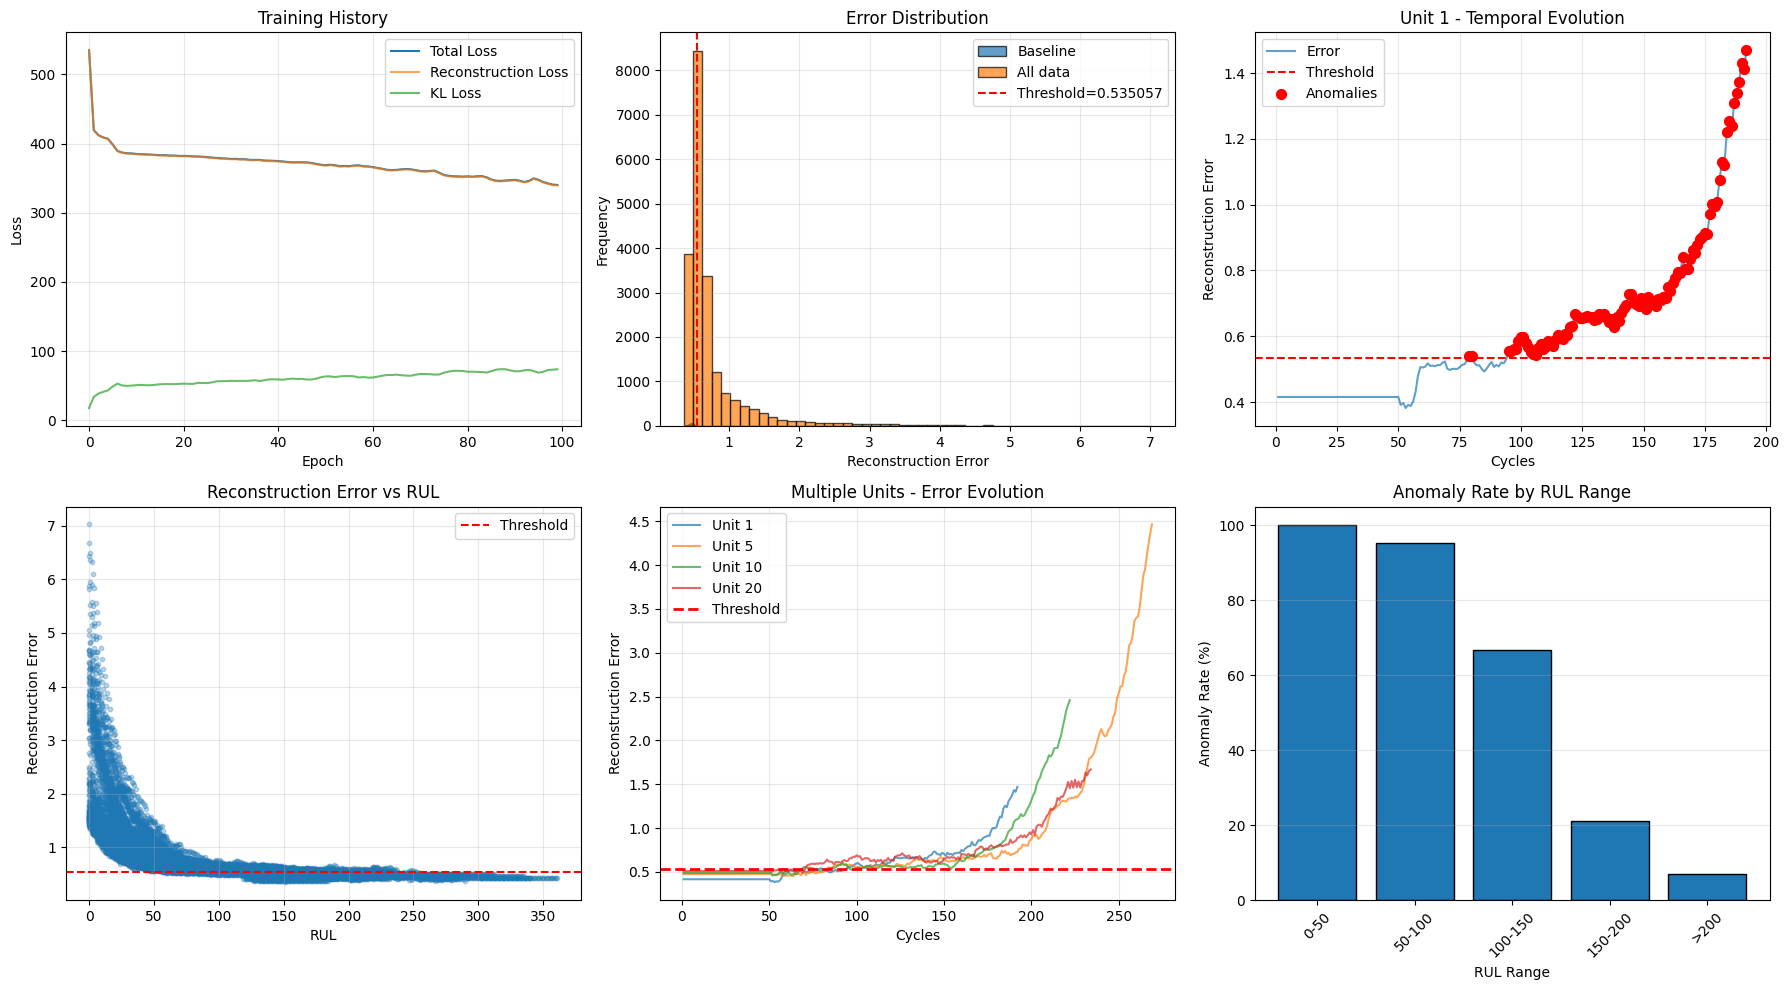

In [ ]:
# 12. VISUALIZACIÓN
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# a) Historia del entrenamiento
axes[0, 0].plot(history.history['total_loss'], label='Total Loss')
axes[0, 0].plot(history.history['reconstruction_loss'], label='Reconstruction Loss', alpha=0.7)
axes[0, 0].plot(history.history['kl_loss'], label='KL Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# b) Distribución de errores
axes[0, 1].hist(baseline_errors, bins=50, alpha=0.7, label='Baseline', edgecolor='black')
axes[0, 1].hist(train['reconstruction_error'], bins=50, alpha=0.7, label='All data', edgecolor='black')
axes[0, 1].axvline(threshold, color='r', linestyle='--', label=f'Threshold={threshold:.6f}')
axes[0, 1].set_xlabel('Reconstruction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Error Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# c) Evolución temporal ejemplo (unidad 1)
unit_1 = train[train['unit_id'] == 1]
axes[0, 2].plot(unit_1['time_cycles'], unit_1['reconstruction_error'], label='Error', alpha=0.7)
axes[0, 2].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[0, 2].scatter(unit_1[unit_1['is_anomaly']==1]['time_cycles'], 
                   unit_1[unit_1['is_anomaly']==1]['reconstruction_error'], 
                   color='red', s=50, label='Anomalies', zorder=3)
axes[0, 2].set_xlabel('Cycles')
axes[0, 2].set_ylabel('Reconstruction Error')
axes[0, 2].set_title('Unit 1 - Temporal Evolution')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# d) Error vs RUL
axes[1, 0].scatter(train['RUL'], train['reconstruction_error'], alpha=0.3, s=10)
axes[1, 0].axhline(threshold, color='r', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('RUL')
axes[1, 0].set_ylabel('Reconstruction Error')
axes[1, 0].set_title('Reconstruction Error vs RUL')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# e) Evolución temporal para múltiples unidades
for unit_id in [1, 5, 10, 20]:
    unit_data = train[train['unit_id'] == unit_id]
    axes[1, 1].plot(unit_data['time_cycles'], unit_data['reconstruction_error'], 
                    label=f'Unit {unit_id}', alpha=0.7)
axes[1, 1].axhline(threshold, color='r', linestyle='--', label='Threshold', linewidth=2)
axes[1, 1].set_xlabel('Cycles')
axes[1, 1].set_ylabel('Reconstruction Error')
axes[1, 1].set_title('Multiple Units - Error Evolution')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# f) Tasa de anomalías por RUL bin
train['rul_bin'] = pd.cut(train['RUL'], bins=[0, 50, 100, 150, 200, 300], 
                          labels=['0-50', '50-100', '100-150', '150-200', '>200'])
anomaly_rate = train.groupby('rul_bin')['is_anomaly'].mean() * 100
axes[1, 2].bar(range(len(anomaly_rate)), anomaly_rate.values, edgecolor='black')
axes[1, 2].set_xticks(range(len(anomaly_rate)))
axes[1, 2].set_xticklabels(anomaly_rate.index, rotation=45)
axes[1, 2].set_xlabel('RUL Range')
axes[1, 2].set_ylabel('Anomaly Rate (%)')
axes[1, 2].set_title('Anomaly Rate by RUL Range')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/tcn_vae_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


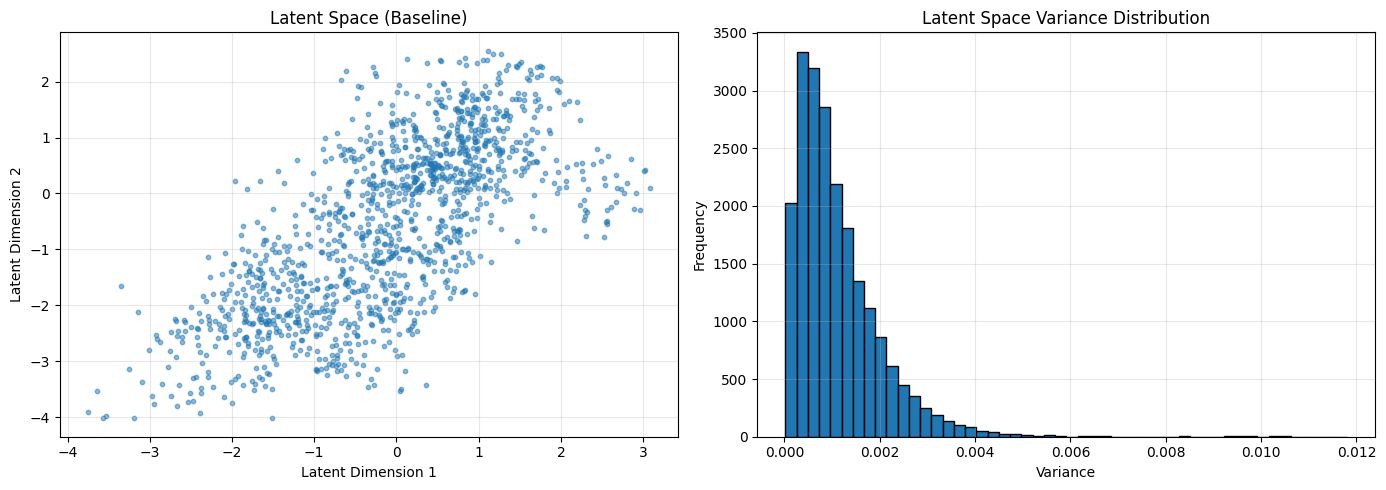

In [ ]:
# 13. VISUALIZAR ESPACIO LATENTE
# Obtener representación latente del baseline
z_mean, z_log_var, z = encoder.predict(X_baseline)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Primeras 2 dimensiones del espacio latente
axes[0].scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5, s=10)
axes[0].set_xlabel('Latent Dimension 1')
axes[0].set_ylabel('Latent Dimension 2')
axes[0].set_title('Latent Space (Baseline)')
axes[0].grid(alpha=0.3)

# Distribución de varianzas
axes[1].hist(np.exp(z_log_var).flatten(), bins=50, edgecolor='black')
axes[1].set_xlabel('Variance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Latent Space Variance Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/tcn_vae_latent_space.png', dpi=150, bbox_inches='tight')
plt.show()

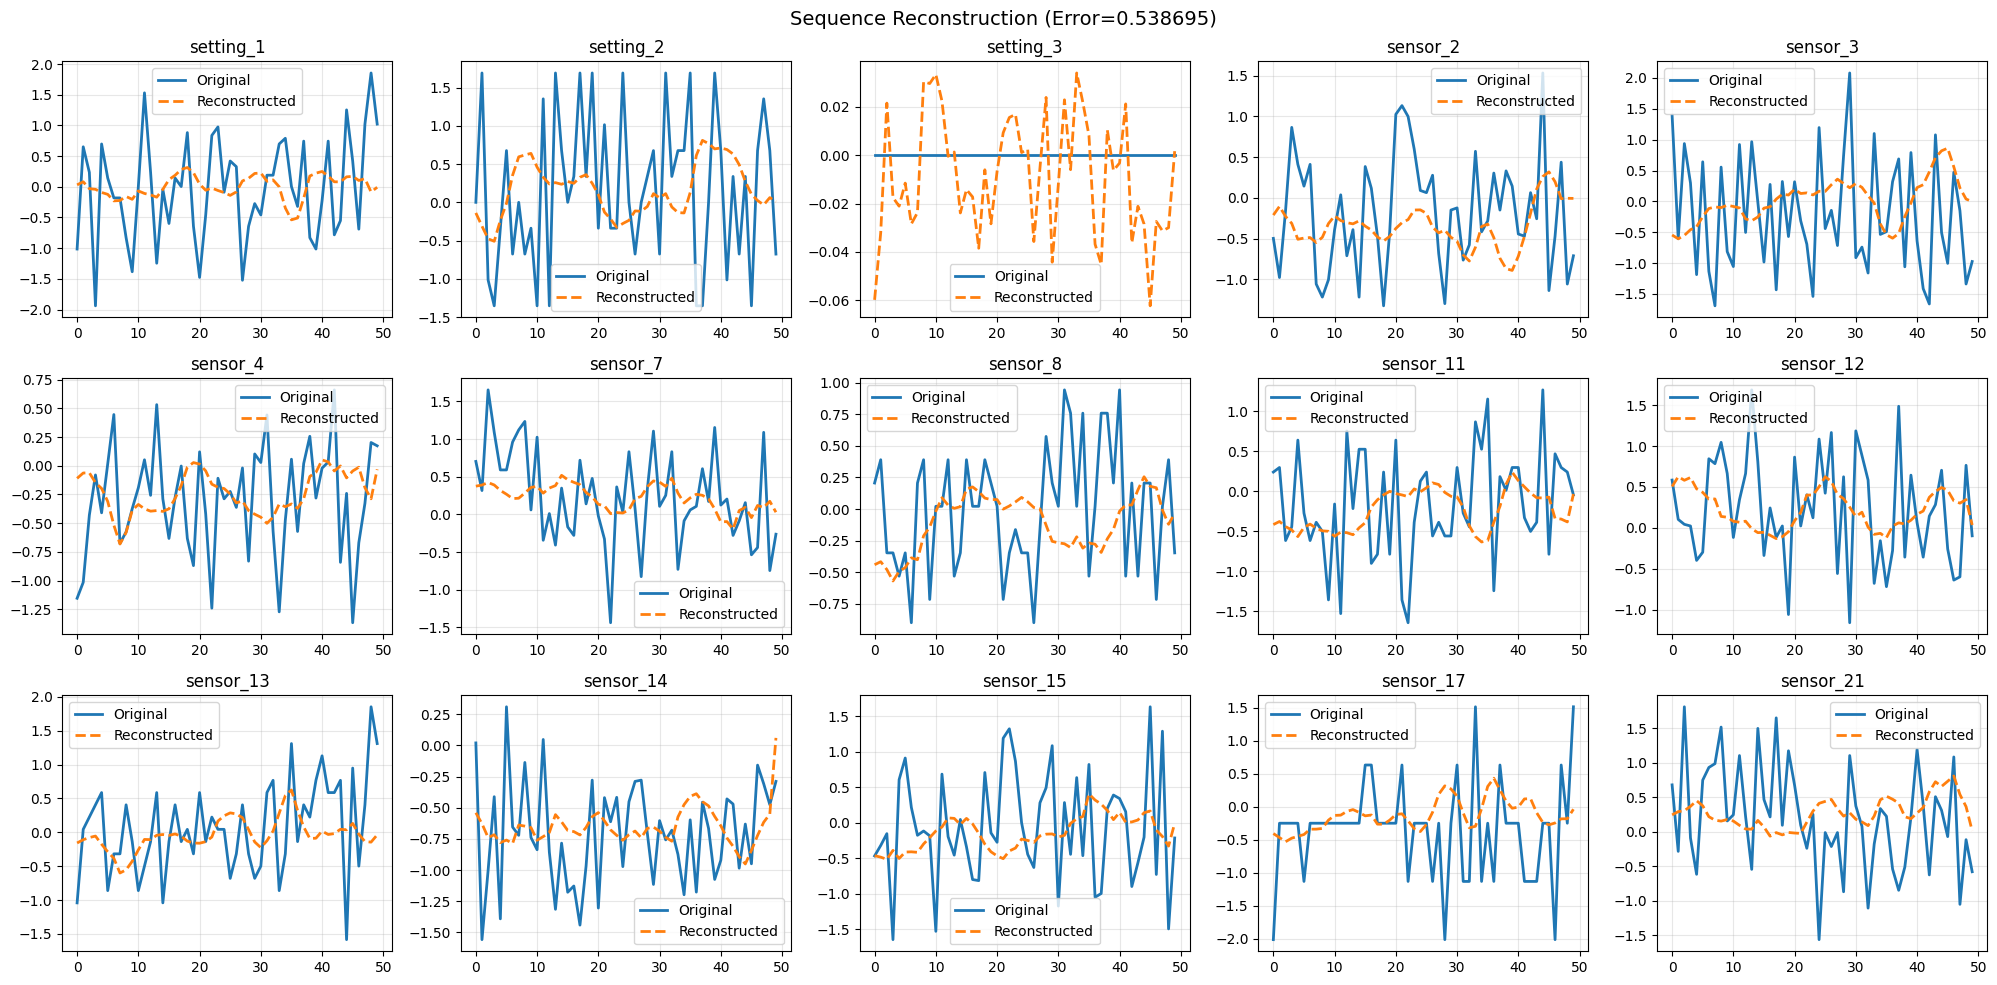

In [ ]:
# 14. VISUALIZAR EJEMPLO DE RECONSTRUCCIÓN
# Seleccionar una secuencia anómala
anomalous_idx = np.where(sequence_errors > threshold)[0][0]
original_seq = X_train[anomalous_idx]
reconstructed_seq = X_train_reconstructed[anomalous_idx]

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    axes[i].plot(original_seq[:, i], label='Original', linewidth=2)
    axes[i].plot(reconstructed_seq[:, i], label='Reconstructed', linestyle='--', linewidth=2)
    axes[i].set_title(feature)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle(f'Sequence Reconstruction (Error={sequence_errors[anomalous_idx]:.6f})', fontsize=14)
plt.tight_layout()
plt.savefig('./outputs/tcn_vae_sequence_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 15. GUARDAR RESULTADOS
output_dir = Path('./outputs')
output_dir.mkdir(exist_ok=True)

# Anomalías detectadas
train[['unit_id', 'time_cycles', 'RUL', 'reconstruction_error', 'is_anomaly']].to_csv(
    output_dir / 'tcn_vae_anomalies.csv', index=False
)

# Métricas
pd.DataFrame([metrics]).to_csv(
    output_dir / 'tcn_vae_metrics.csv', index=False
)

print("\n✅ Resultados guardados en ./outputs/")
print(f"   - tcn_vae_anomalies.csv")
print(f"   - tcn_vae_metrics.csv")
print(f"   - tcn_vae_analysis.png")
print(f"   - tcn_vae_latent_space.png")
print(f"   - tcn_vae_sequence_reconstruction.png")
print(f"   - tcn_vae_model.keras")


✅ Resultados guardados en ./outputs/
   - tcn_vae_anomalies.csv
   - tcn_vae_metrics.csv
   - tcn_vae_analysis.png
   - tcn_vae_latent_space.png
   - tcn_vae_sequence_reconstruction.png
   - tcn_vae_model.keras
